# Modeling and Evaluation

## Summary

This notebook implements and evaluates machine learning models to predict tree cover loss based on historical data and deforestation drivers. Multiple regression algorithms are tested and compared.

## Models Implemented

1. **Linear Regression**: 
   - Baseline model for comparison
   - Simple interpretable relationships

2. **Random Forest Regression**:
   - Handles nonlinear effects and feature interactions
   - Robust to outliers and missing values

3. **XGBoost**:
   - Gradient boosting for high accuracy
   - Effective for structured environmental data

## Evaluation Metrics

- **RMSE** (Root Mean Squared Error): Measures prediction error magnitude
- **MAE** (Mean Absolute Error): Average absolute prediction error
- **R²** (Coefficient of Determination): Proportion of variance explained
- **MASE** (Mean Absolute Scaled Error): Scaled error for interpretability

## Key Activities

1. **Data Preprocessing**: Feature engineering, scaling, train-test split
2. **Model Training**: Fit each model on training data
3. **Model Evaluation**: Compare performance across all metrics
4. **Feature Importance**: Identify most predictive features
5. **Predictions**: Generate forecasts for future years (2025-2035)

## Output

- Trained model files saved to `models/`
- Performance comparison across models
- Feature importance rankings
- Future predictions for tree cover loss

---


## 1. Loading the merged dataset


In [1]:
## 1️⃣ Import Libraries and Load Data

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
df = pd.read_csv("../data/processed/merged_clean_data.csv")
print(f"✅ Loaded dataset: {df.shape}")
print(f"   Columns: {len(df.columns)}")
df.head()


✅ Loaded dataset: (3985, 24)
   Columns: 24


,country,threshold,area_ha_x,extent_2000_ha,extent_2010_ha,gain_2000-2012_ha,tree_cover_loss_ha,year,area_ha_y,primary_forest_loss_ha,...,settlements_infrastructure,shifting_cultivation,wildfire,umd_tree_cover_extent_2000__ha,gfw_aboveground_carbon_stocks_2000__mg_c,avg_gfw_aboveground_carbon_stocks_2000__mg_c_ha-1,gfw_forest_carbon_gross_emissions__mg_co2e_yr-1,gfw_forest_carbon_gross_removals__mg_co2_yr-1,gfw_forest_carbon_net_flux__mg_co2e_yr-1,carbon_gross_emissions_MgCO2e
0,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,88.0,2001,0.0,0.0,...,0.0,0.0,1.0,205771.0,12409398.0,123.0,15339.0,376800.0,-361461.0,27986.0
1,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,179.0,2002,0.0,0.0,...,0.0,0.0,34.0,205771.0,12409398.0,123.0,15339.0,376800.0,-361461.0,41762.0
2,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,244.0,2003,0.0,0.0,...,0.0,0.0,134.0,205771.0,12409398.0,123.0,15339.0,376800.0,-361461.0,47255.0
3,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,201.0,2004,0.0,0.0,...,0.0,0.0,13.0,205771.0,12409398.0,123.0,15339.0,376800.0,-361461.0,34770.0
4,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,236.0,2005,0.0,0.0,...,0.0,0.0,51.0,205771.0,12409398.0,123.0,15339.0,376800.0,-361461.0,39928.0


## 2. Feature Engineering


In [2]:
# Create temporal features
def create_temporal_features(df):
    """Create time-based and lag features."""
    df = df.copy()
    
    # Determine grouping columns
    group_cols = []
    for col in ['country', 'threshold']:
        if col in df.columns:
            group_cols.append(col)
    
    if len(group_cols) == 0:
        print("⚠️ Warning: No grouping columns found, skipping temporal features")
        return df
    
    # Sort by available columns
    sort_cols = group_cols + ['year'] if 'year' in df.columns else group_cols
    if len(sort_cols) > 0:
        df = df.sort_values(sort_cols)
    
    # Lag features (previous year's loss)
    try:
        df['loss_lag1'] = df.groupby(group_cols)['tree_cover_loss_ha'].shift(1)
    except Exception as e:
        print(f"⚠️ Warning: Could not create loss_lag1: {e}")
        df['loss_lag1'] = np.nan
    
    # Rolling averages
    try:
        df['loss_rolling_mean_3y'] = df.groupby(group_cols)['tree_cover_loss_ha'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
    except Exception as e:
        print(f"⚠️ Warning: Could not create loss_rolling_mean_3y: {e}")
        df['loss_rolling_mean_3y'] = np.nan
    
    # Years since 2000
    if 'year' in df.columns:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df['years_since_2000'] = df['year'] - 2000
    
    # Remaining forest
    try:
        df['cumulative_loss'] = df.groupby(group_cols)['tree_cover_loss_ha'].cumsum()
        if 'extent_2000_ha' in df.columns:
            df['extent_2000_ha'] = pd.to_numeric(df['extent_2000_ha'], errors='coerce')
            df['remaining_forest'] = (df['extent_2000_ha'] - df['cumulative_loss']).clip(lower=0)
            df['remaining_forest_pct'] = (df['remaining_forest'] / (df['extent_2000_ha'] + 1) * 100).clip(0, 100)
    except Exception as e:
        print(f"⚠️ Warning: Could not create remaining forest features: {e}")
        if 'cumulative_loss' not in df.columns:
            df['cumulative_loss'] = np.nan
        if 'remaining_forest' not in df.columns:
            df['remaining_forest'] = np.nan
        if 'remaining_forest_pct' not in df.columns:
            df['remaining_forest_pct'] = np.nan
    
    return df

# Apply preprocessing
print("Processing data...")
print(f"Initial columns: {list(df.columns)[:10]}...")  # Show first 10 columns
df = create_temporal_features(df)
print(f"✅ Processed dataset: {df.shape}")
df.head()

Processing data...
Initial columns: ['country', 'threshold', 'area_ha_x', 'extent_2000_ha', 'extent_2010_ha', 'gain_2000-2012_ha', 'tree_cover_loss_ha', 'year', 'area_ha_y', 'primary_forest_loss_ha']...
✅ Processed dataset: (3985, 30)


,country,threshold,area_ha_x,extent_2000_ha,extent_2010_ha,gain_2000-2012_ha,tree_cover_loss_ha,year,area_ha_y,primary_forest_loss_ha,...,gfw_forest_carbon_gross_emissions__mg_co2e_yr-1,gfw_forest_carbon_gross_removals__mg_co2_yr-1,gfw_forest_carbon_net_flux__mg_co2e_yr-1,carbon_gross_emissions_MgCO2e,loss_lag1,loss_rolling_mean_3y,years_since_2000,cumulative_loss,remaining_forest,remaining_forest_pct
0,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,88.0,2001,0.0,0.0,...,15339.0,376800.0,-361461.0,27986.0,NaN,88.000000,1,88.0,205683.0,99.956748
1,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,179.0,2002,0.0,0.0,...,15339.0,376800.0,-361461.0,41762.0,88.0,133.500000,2,267.0,205504.0,99.869759
2,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,244.0,2003,0.0,0.0,...,15339.0,376800.0,-361461.0,47255.0,179.0,170.333333,3,511.0,205260.0,99.751181
3,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,201.0,2004,0.0,0.0,...,15339.0,376800.0,-361461.0,34770.0,244.0,208.000000,4,712.0,205059.0,99.653500
4,Afghanistan,30,64383655.0,205771.0,71786.0,10738.0,236.0,2005,0.0,0.0,...,15339.0,376800.0,-361461.0,39928.0,201.0,227.000000,5,948.0,204823.0,99.538810


## 3. Feature Selection and Data Splitting for modelling


In [3]:
# Define target and features
target = "tree_cover_loss_ha"
features = [
    "year", "years_since_2000",
    "threshold",
    "loss_lag1", "loss_rolling_mean_3y",
    "hard_commodities", "logging", "wildfire",
    "permanent_agriculture", "shifting_cultivation",
    "gfw_forest_carbon_net_flux__mg_co2e_yr-1",
    "carbon_gross_emissions_MgCO2e",
    "primary_forest_loss_ha",
    "umd_tree_cover_extent_2000__ha",
    "gfw_aboveground_carbon_stocks_2000__mg_c"
]

# # Remove rows with missing target
# df = df.dropna(subset=[target, "country"])

# # Ensure target is numeric
# df[target] = pd.to_numeric(df[target], errors='coerce')
# df = df.dropna(subset=[target])  # Remove rows where target couldn't be converted

# Encode country
df_enc = pd.get_dummies(df, columns=["country"], drop_first=True)
X = df_enc[features + [c for c in df_enc.columns if c.startswith("country_")]]
y = df_enc[target]

# Convert all feature columns to numeric (handles empty strings, etc.)
print("\nConverting all features to numeric...")
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill any remaining NaN values in features with 0 (for missing temporal features)
X = X.fillna(0)

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(0)

print(f"\n✅ Final dataset shape: {X.shape}")
print(f"   Target variable: {target}")
print(f"   Feature dtypes: {X}")

# Time-based split (important for time series data)
# Train: 2001-2019, Test: 2020-2024
train_mask = df_enc['year'] <= 2019
test_mask = df_enc['year'] >= 2020

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Final check: ensure all are numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

print(f"\n Data Split:")
print(f"   Train: {len(X_train):,} samples (2001-2019)")
print(f"   Test:  {len(X_test):,} samples (2020-2024)")
print(f"   X_train dtype: {X_train.dtypes.value_counts().to_dict()}")
print(f"   y_train dtype: {y_train.dtype}")



Converting all features to numeric...

✅ Final dataset shape: (3985, 181)
   Target variable: tree_cover_loss_ha
   Feature dtypes:       year  years_since_2000  threshold  loss_lag1  loss_rolling_mean_3y  \
0     2001                 1         30        0.0             88.000000   
1     2002                 2         30       88.0            133.500000   
2     2003                 3         30      179.0            170.333333   
3     2004                 4         30      244.0            208.000000   
4     2005                 5         30      201.0            227.000000   
...    ...               ...        ...        ...                   ...   
3980  2020                20         30     2361.0           1218.333333   
3981  2021                21         30      674.0           1463.333333   
3982  2022                22         30     1355.0           1065.333333   
3983  2023                23         30     1167.0           1205.000000   
3984  2024                24   

## 4. Model Training and Evaluation

We train three models and compare their performance using R² and RMSE.


## 4.1 Evaluation helper method

In [4]:
# Evaluation function with all metrics
def calculate_mase(y_true, y_pred, y_train=None):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    MASE = MAE / MAE_naive_forecast
    where naive forecast is the mean of training data (or previous value for time series)
    """
    mae = mean_absolute_error(y_true, y_pred)
    
    if y_train is not None:
        # Use mean of training data as naive forecast
        naive_forecast = np.mean(y_train)
        mae_naive = mean_absolute_error(y_true, np.full_like(y_true, naive_forecast))
    else:
        # Use mean of test data as fallback
        naive_forecast = np.mean(y_true)
        mae_naive = mean_absolute_error(y_true, np.full_like(y_true, naive_forecast))
    
    if mae_naive == 0:
        return np.inf if mae > 0 else 0.0
    
    mase = mae / mae_naive
    return mase

def evaluate_model(y_true, y_pred, model_name, y_train=None):
    """Evaluate model using RMSE, MAE, R², and MASE."""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mase = calculate_mase(y_true, y_pred, y_train)
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE:      {rmse:,.2f} ha")
    print(f"  MAE:       {mae:,.2f} ha")
    print(f"  R² Score:  {r2:.4f}")
    print(f"  MASE:      {mase:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MASE': mase}

# Store results
results = {}


### 4.2 Linear Regression


Training Linear Regression (Baseline)...

Linear Regression Performance:
  RMSE:      17,768.62 ha
  MAE:       4,318.19 ha
  R² Score:  0.9992
  MASE:      0.0215


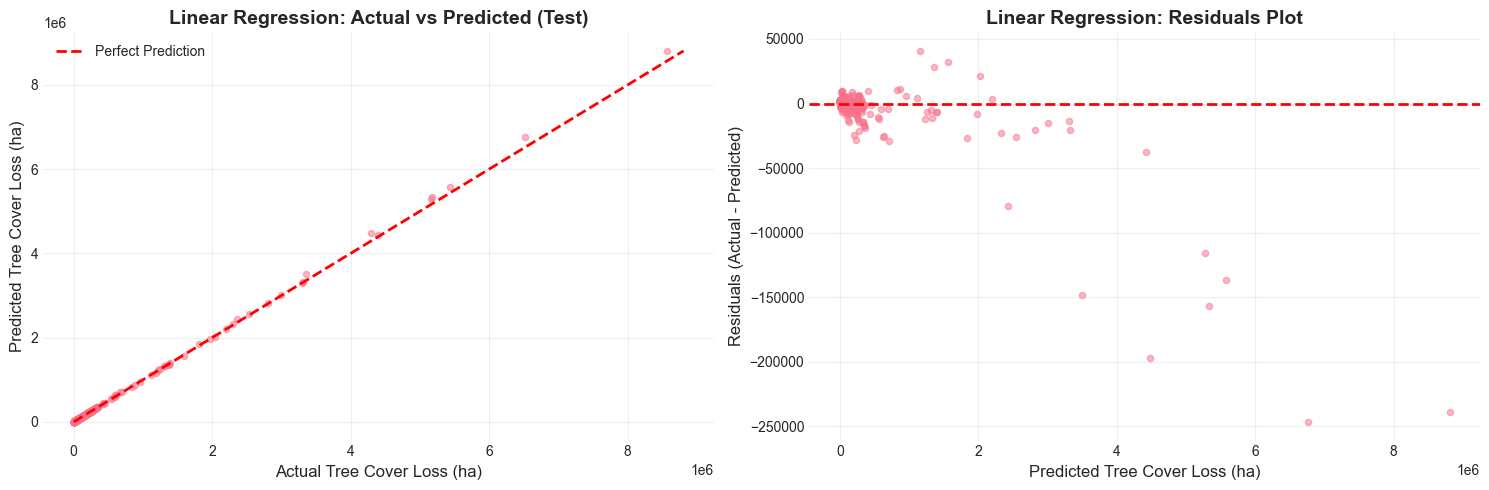

In [5]:
# Train Linear Regression baseline
print("=" * 60)
print("Training Linear Regression (Baseline)...")
print("=" * 60)

lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate
y_pred_lr = lr.predict(X_test)
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr, "Linear Regression", y_train)

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Actual vs Predicted (Test)
axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=20)
max_val = max(y_test.max(), y_pred_lr.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
axes[0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0].set_title('Linear Regression: Actual vs Predicted (Test)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_pred_lr
axes[1].scatter(y_pred_lr, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Linear Regression: Residuals Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4.3 Random Forest Regression


Random Forest

Performing RandomizedSearchCV for Random Forest...
This may take a few minutes...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

 Best parameters found:
   n_estimators: 300
   min_samples_split: 10
   min_samples_leaf: 2
   max_samples: 0.9
   max_features: sqrt
   max_depth: 10

Random Forest Performance:
  RMSE:      249,507.52 ha
  MAE:       36,838.79 ha
  R² Score:  0.8431
  MASE:      0.1831


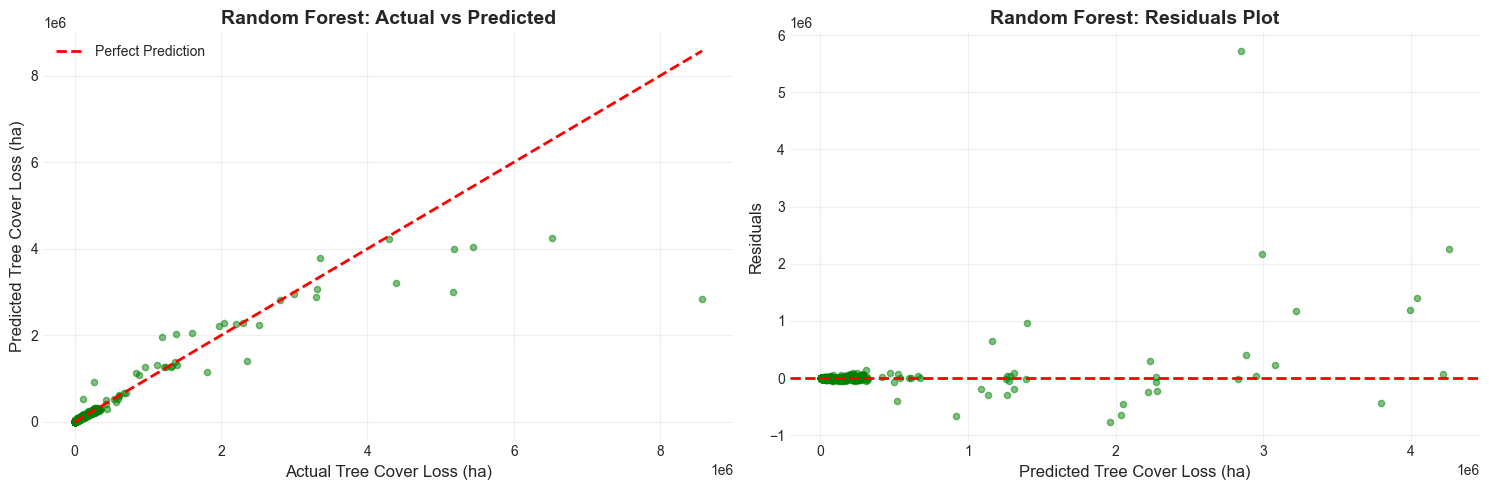

In [6]:
# Hyperparameter Tuning for Random Forest
print("=" * 60)
print("Random Forest")
print("=" * 60)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [8, 10, 12, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.7, 0.8, 0.9]
}

# Use RandomizedSearchCV for faster tuning
print("\nPerforming RandomizedSearchCV for Random Forest...")
print("This may take a few minutes...")

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=30,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train, y_train)

print(f"\n Best parameters found:")
for param, value in rf_random.best_params_.items():
    print(f"   {param}: {value}")

# Train best model
rf_tuned = rf_random.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test)
rf_tuned_score = evaluate_model(y_test, y_pred_rf_tuned, "Random Forest", y_train)

# Update results
results['Random Forest'] = rf_tuned_score

# Visualize tuned model predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test, y_pred_rf_tuned, alpha=0.5, s=20, color='green')
max_val = max(y_test.max(), y_pred_rf_tuned.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
axes[0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0].set_title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_rf_tuned
axes[1].scatter(y_pred_rf_tuned, residuals, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Random Forest: Residuals Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



XGBoost
Fitting 3 folds for each of 30 candidates, totalling 90 fits

 Best parameters found:
   subsample: 0.8
   reg_lambda: 1.5
   reg_alpha: 0.5
   n_estimators: 500
   min_child_weight: 3
   max_depth: 6
   learning_rate: 0.05
   gamma: 0.1
   colsample_bytree: 0.7

XGBoost Performance:
  RMSE:      174,535.79 ha
  MAE:       19,888.77 ha
  R² Score:  0.9232
  MASE:      0.0989


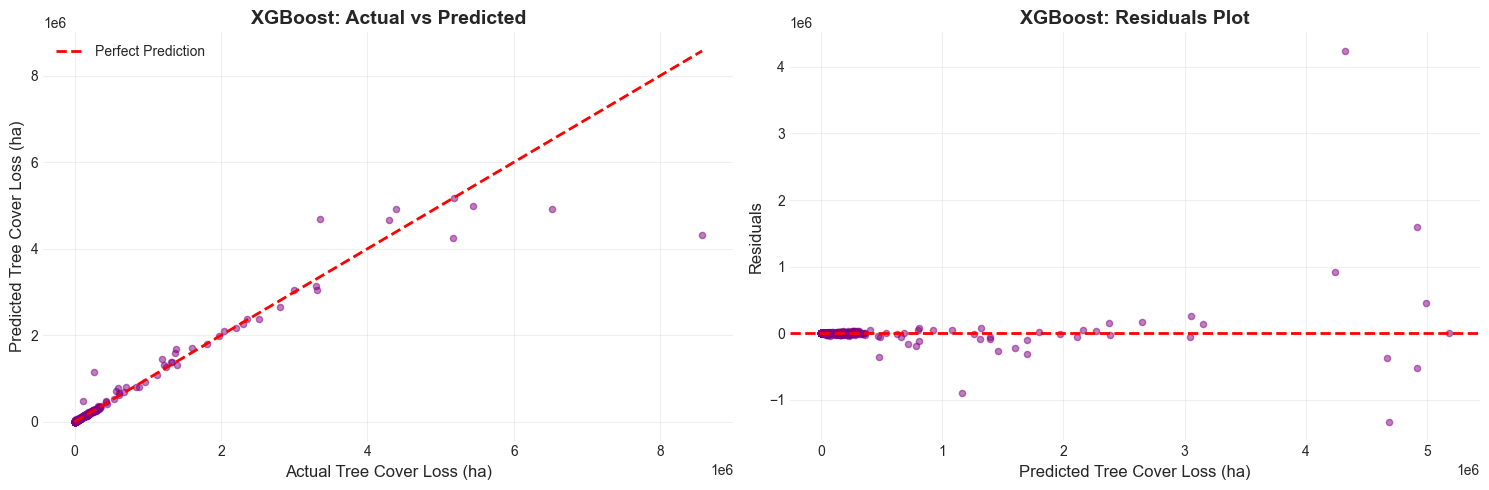

In [7]:
# Hyperparameter Tuning for XGBoost
print("\n" + "=" * 60)
print("XGBoost")
print("=" * 60)

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=xgb_param_grid,
    n_iter=30,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_random.fit(X_train, y_train)

print(f"\n Best parameters found:")
for param, value in xgb_random.best_params_.items():
    print(f"   {param}: {value}")

# Train best model
xgb_tuned = xgb_random.best_estimator_
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
xgb_tuned_score = evaluate_model(y_test, y_pred_xgb_tuned, "XGBoost", y_train)

# Update results
results['XGBoost'] = xgb_tuned_score

# Visualize tuned model predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test, y_pred_xgb_tuned, alpha=0.5, s=20, color='purple')
max_val = max(y_test.max(), y_pred_xgb_tuned.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
axes[0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0].set_title('XGBoost: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_xgb_tuned
axes[1].scatter(y_pred_xgb_tuned, residuals, alpha=0.5, s=20, color='purple')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('XGBoost: Residuals Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store the tuned models as the main models
rf = rf_tuned
xgb = xgb_tuned
y_pred_rf = y_pred_rf_tuned
y_pred_xgb = y_pred_xgb_tuned


## 5. Model Performance Analysis

Let's analyze why Linear Regression might be performing better than tree-based models.


DIAGNOSTIC ANALYSIS

3. Overfitting Check:
   Linear Regression:
      Train R²: 0.9993, Test R²: 0.9992, Gap: 0.0001
   Random Forest:
      Train R²: 0.9710, Test R²: 0.8431, Gap: 0.1279
   XGBoost:
      Train R²: 1.0000, Test R²: 0.9232, Gap: 0.0767


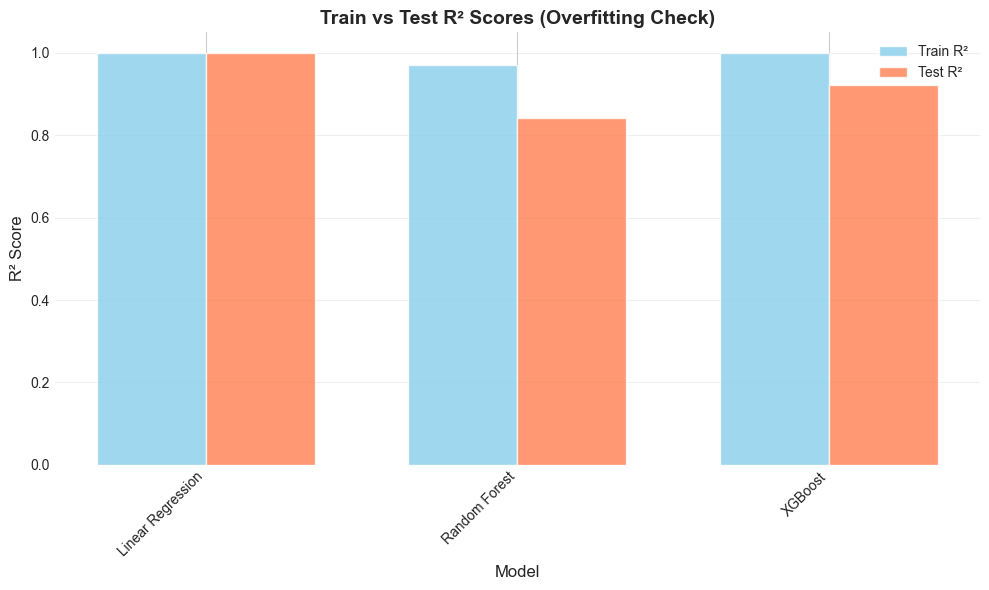


5. Linearity Check (Top Correlations):


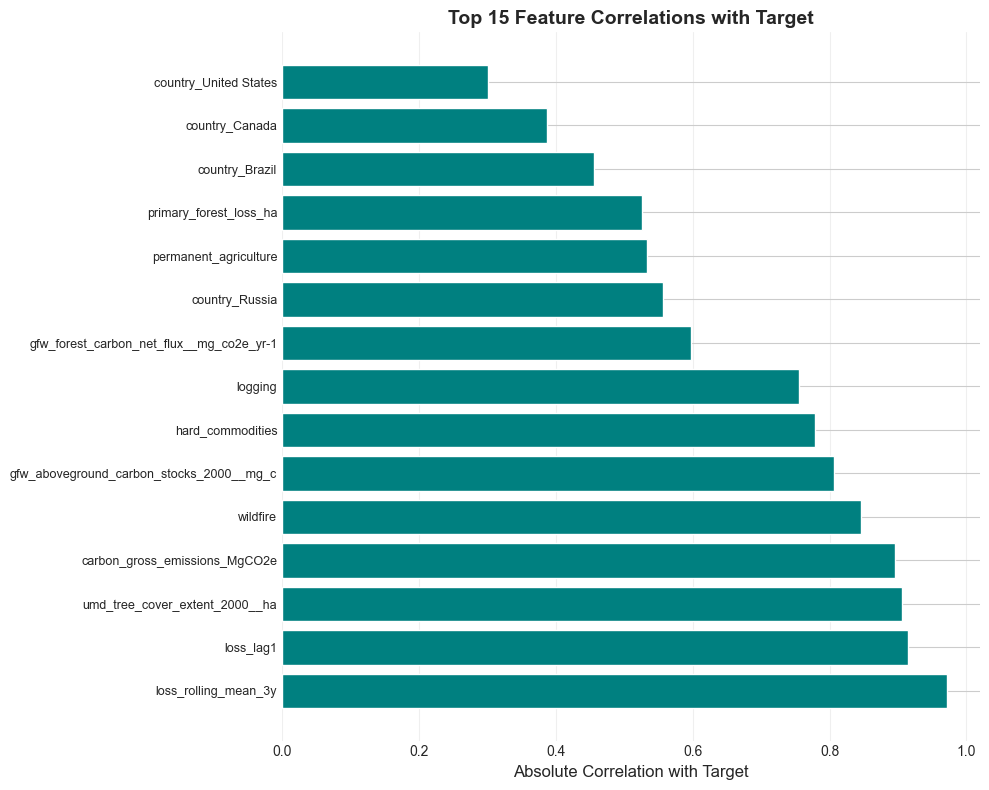

In [8]:
# Diagnostic Analysis: Why Linear Regression Might Perform Better

print("=" * 60)
print("DIAGNOSTIC ANALYSIS")
print("=" * 60)


# 3. Check for overfitting
print("\n3. Overfitting Check:")
if 'rf' in locals() and 'xgb' in locals():
    train_r2_rf = r2_score(y_train, rf.predict(X_train))
    test_r2_rf = r2_score(y_test, rf.predict(X_test))
    train_r2_xgb = r2_score(y_train, xgb.predict(X_train))
    test_r2_xgb = r2_score(y_test, xgb.predict(X_test))
    train_r2_lr = r2_score(y_train, lr.predict(X_train))
    test_r2_lr = r2_score(y_test, lr.predict(X_test))
    
    print(f"   Linear Regression:")
    print(f"      Train R²: {train_r2_lr:.4f}, Test R²: {test_r2_lr:.4f}, Gap: {train_r2_lr - test_r2_lr:.4f}")
    print(f"   Random Forest:")
    print(f"      Train R²: {train_r2_rf:.4f}, Test R²: {test_r2_rf:.4f}, Gap: {train_r2_rf - test_r2_rf:.4f}")
    print(f"   XGBoost:")
    print(f"      Train R²: {train_r2_xgb:.4f}, Test R²: {test_r2_xgb:.4f}, Gap: {train_r2_xgb - test_r2_xgb:.4f}")
    
    # Visualize overfitting
    fig, ax = plt.subplots(figsize=(10, 6))
    models = ['Linear Regression', 'Random Forest', 'XGBoost']
    train_scores = [train_r2_lr, train_r2_rf, train_r2_xgb]
    test_scores = [test_r2_lr, test_r2_rf, test_r2_xgb]
    x = np.arange(len(models))
    width = 0.35
    ax.bar(x - width/2, train_scores, width, label='Train R²', color='skyblue', alpha=0.8)
    ax.bar(x + width/2, test_scores, width, label='Test R²', color='coral', alpha=0.8)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_title('Train vs Test R² Scores (Overfitting Check)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


# 5. Check for linear relationships
print("\n5. Linearity Check (Top Correlations):")
correlations = X.corrwith(y).abs().sort_values(ascending=False)
    
# Visualize top correlations
top_corrs = correlations.head(15)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top_corrs)), top_corrs.values, color='teal')
ax.set_yticks(range(len(top_corrs)))
ax.set_yticklabels(top_corrs.index.values, fontsize=9)
ax.set_xlabel('Absolute Correlation with Target', fontsize=12)
ax.set_title('Top 15 Feature Correlations with Target', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### 6. Compare all models


MODEL COMPARISON SUMMARY

                            RMSE           MAE        R²      MASE
Linear Regression   17768.620098   4318.188056  0.999204  0.021463
XGBoost            174535.787963  19888.774055  0.923243  0.098855
Random Forest      249507.517538  36838.790578  0.843139  0.183104


🏆 Best Model: Linear Regression
   R² Score:  0.9992
   RMSE:      17,768.62 ha


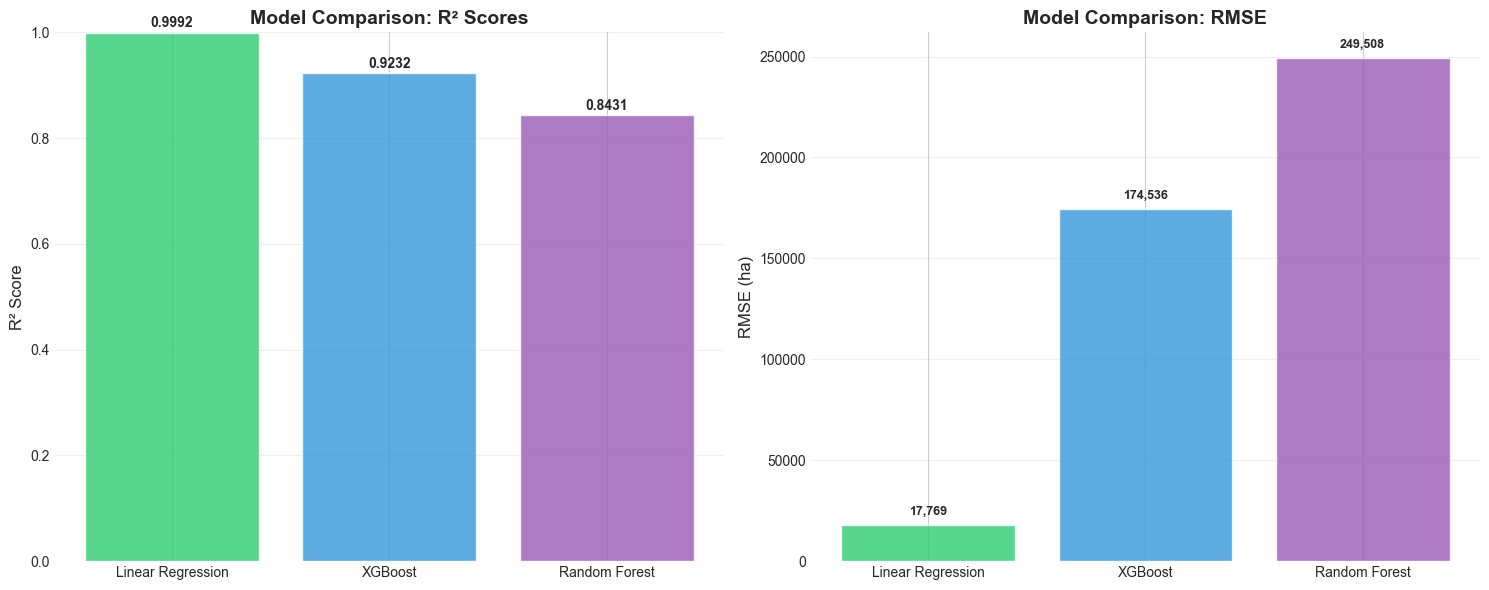

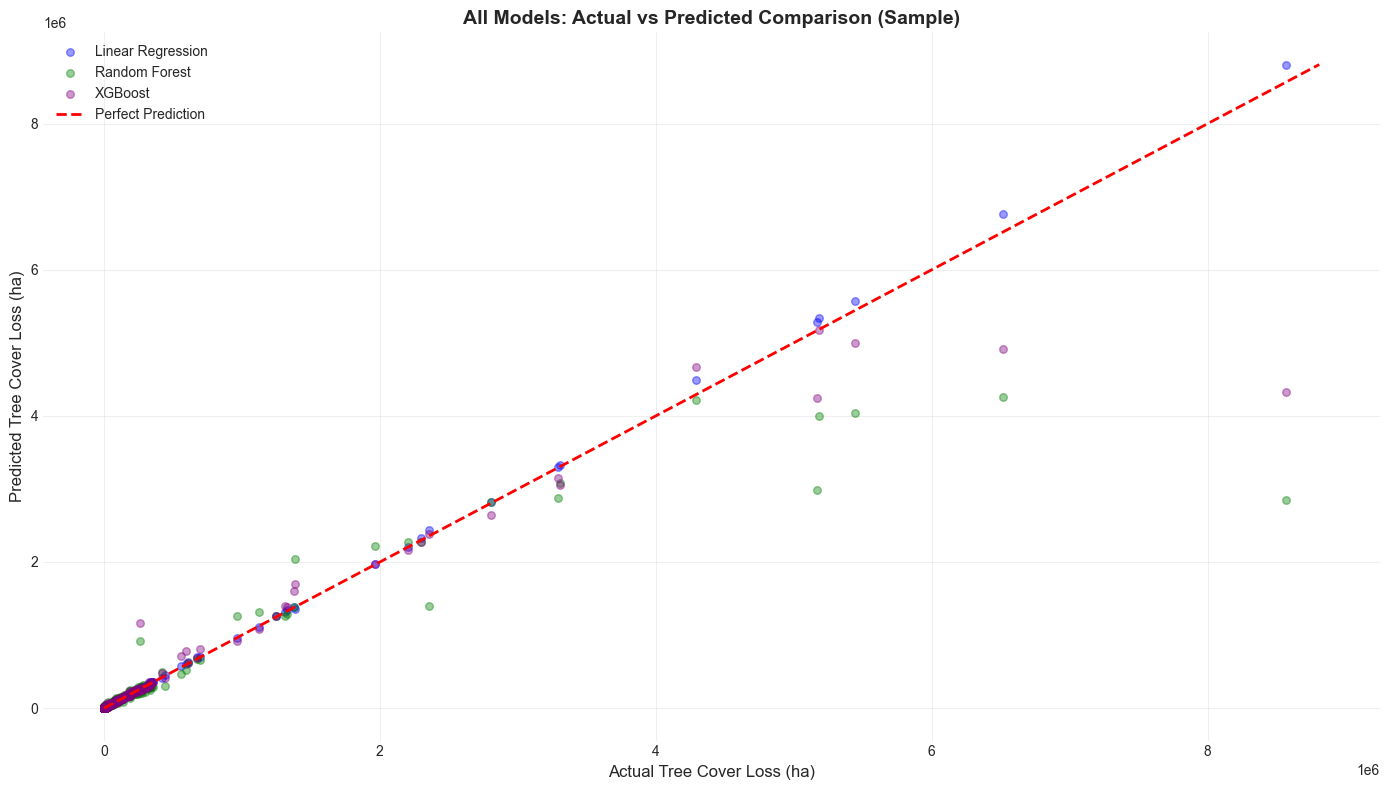

In [9]:
# Compare all models
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("\n" + comparison_df.to_string())
print("\n" + "=" * 60)

# Identify best model
best_model_name = comparison_df.index[0]
best_r2 = comparison_df.loc[best_model_name, 'R²']
best_rmse = comparison_df.loc[best_model_name, 'RMSE']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R² Score:  {best_r2:.4f}")
print(f"   RMSE:      {best_rmse:,.2f} ha")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
axes[0].bar(comparison_df.index, comparison_df['R²'], color=['#2ecc71', '#3498db', '#9b59b6'], alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison: R² Scores', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['R²']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# RMSE comparison
axes[1].bar(comparison_df.index, comparison_df['RMSE'], color=['#2ecc71', '#3498db', '#9b59b6'], alpha=0.8)
axes[1].set_ylabel('RMSE (ha)', fontsize=12)
axes[1].set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['RMSE']):
    axes[1].text(i, v + 5000, f'{v:,.0f}', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Combined predictions comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Sample a subset of test data for visualization
sample_indices = np.random.choice(len(y_test), min(500, len(y_test)), replace=False)
y_test_sample = y_test.iloc[sample_indices] if hasattr(y_test, 'iloc') else y_test[sample_indices]
y_pred_lr_sample = y_pred_lr[sample_indices]
y_pred_rf_sample = y_pred_rf[sample_indices]
y_pred_xgb_sample = y_pred_xgb[sample_indices]

ax.scatter(y_test_sample, y_pred_lr_sample, alpha=0.4, s=30, label='Linear Regression', color='blue')
ax.scatter(y_test_sample, y_pred_rf_sample, alpha=0.4, s=30, label='Random Forest', color='green')
ax.scatter(y_test_sample, y_pred_xgb_sample, alpha=0.4, s=30, label='XGBoost', color='purple')

max_val = max(y_test_sample.max(), y_pred_lr_sample.max(), y_pred_rf_sample.max(), y_pred_xgb_sample.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
ax.set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
ax.set_title('All Models: Actual vs Predicted Comparison (Sample)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Save Best Model


In [10]:
# Select best model
if best_model_name == 'Linear Regression':
    best_model = lr
elif best_model_name == 'Random Forest':
    best_model = rf
else:
    best_model = xgb

# Save best model
model_bundle = {
    "model": best_model,
    "model_name": best_model_name,
    "features": X.columns.tolist(),
    "metrics": {
        "R²": float(best_r2),
        "RMSE": float(best_rmse)
    },
    "comparison": comparison_df.to_dict('index')
}

joblib.dump(model_bundle, "../models/tree_cover_loss_model.pkl")
print(f"\n✅ Saved best model ({best_model_name}) to ../models/tree_cover_loss_model.pkl")



✅ Saved best model (Linear Regression) to ../models/tree_cover_loss_model.pkl


## 8. Prediction Helper Functions


In [11]:
# Linear extrapolation helper for future predictions
def linear_extrapolate(years, values, target_year):
    """Return linear extrapolation of values to target_year."""
    # Convert to DataFrame
    s = pd.DataFrame({"year": years, "val": values})
    
    # Convert both columns to numeric, coercing errors to NaN
    s["year"] = pd.to_numeric(s["year"], errors='coerce')
    s["val"] = pd.to_numeric(s["val"], errors='coerce')
    
    # Drop NaN values and duplicates
    s = s.dropna().drop_duplicates().sort_values("year")
    
    if len(s) >= 3:
        # Ensure values are float64
        x = s["year"].values.astype(float)
        y = s["val"].values.astype(float)
        
        # Perform linear regression
        A = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(a * target_year + b)
    
    # If not enough data, return last value or NaN
    if len(s) > 0:
        return float(s["val"].iloc[-1])
    return np.nan

print("✅ Helper functions defined")


✅ Helper functions defined


## 9. Predict for Future Years


In [12]:
# Load saved model
bundle = joblib.load("../models/tree_cover_loss_model.pkl")
model = bundle["model"]
feature_cols = bundle["features"]

def predict_tree_loss_future(country, year):
    """Predict tree cover loss for a country and future year."""
    dff = df[df["country"] == country].copy()
    
    # Filter to threshold 30 if available
    if "threshold" in dff.columns:
        filt = dff[dff["threshold"] == 30]
        if not filt.empty:
            dff = filt
    
    if dff.empty:
        print(f"⚠️ No data for {country}")
        return None
    
    # Get latest data point
    latest = dff.sort_values("year").tail(1).copy()
    
    # Extrapolate features to target year
    base_features = features.copy()
    for col in base_features:
        if col != "year" and col in dff.columns:
            latest[col] = linear_extrapolate(dff["year"], dff[col], year)
    
    latest["year"] = year
    
    # Encode country and align features
    enc = pd.get_dummies(latest, columns=["country"], drop_first=True)
    for c in feature_cols:
        if c not in enc.columns:
            enc[c] = 0
    
    X_future = enc[feature_cols].fillna(0)
    
    # Predict
    pred = model.predict(X_future)[0]
    print(f"Predicted Tree-Cover-Loss in {country} ({year}): {pred:,.0f} ha")
    return pred

# Example predictions
print("Example predictions:")
predict_tree_loss_future("Brazil", 2035)
predict_tree_loss_future("Indonesia", 2030)


Example predictions:
Predicted Tree-Cover-Loss in Brazil (2035): 3,572,488 ha
Predicted Tree-Cover-Loss in Indonesia (2030): 1,497,133 ha


np.float64(1497132.6341893068)

## 9. Generate Forecasts for All Countries (2025-2035)


Generating forecasts for 2025-2035...
Predicted Tree-Cover-Loss in Afghanistan (2025): -2,443 ha
Predicted Tree-Cover-Loss in Afghanistan (2026): -2,613 ha
Predicted Tree-Cover-Loss in Afghanistan (2027): -2,783 ha
Predicted Tree-Cover-Loss in Afghanistan (2028): -2,953 ha
Predicted Tree-Cover-Loss in Afghanistan (2029): -3,122 ha
Predicted Tree-Cover-Loss in Afghanistan (2030): -3,292 ha
Predicted Tree-Cover-Loss in Afghanistan (2031): -3,462 ha
Predicted Tree-Cover-Loss in Afghanistan (2032): -3,632 ha
Predicted Tree-Cover-Loss in Afghanistan (2033): -3,801 ha
Predicted Tree-Cover-Loss in Afghanistan (2034): -3,971 ha
Predicted Tree-Cover-Loss in Albania (2025): -947 ha
Predicted Tree-Cover-Loss in Albania (2026): -1,152 ha
Predicted Tree-Cover-Loss in Albania (2027): -1,358 ha
Predicted Tree-Cover-Loss in Albania (2028): -1,563 ha
Predicted Tree-Cover-Loss in Albania (2029): -1,768 ha
Predicted Tree-Cover-Loss in Albania (2030): -1,974 ha
Predicted Tree-Cover-Loss in Albania (2031):

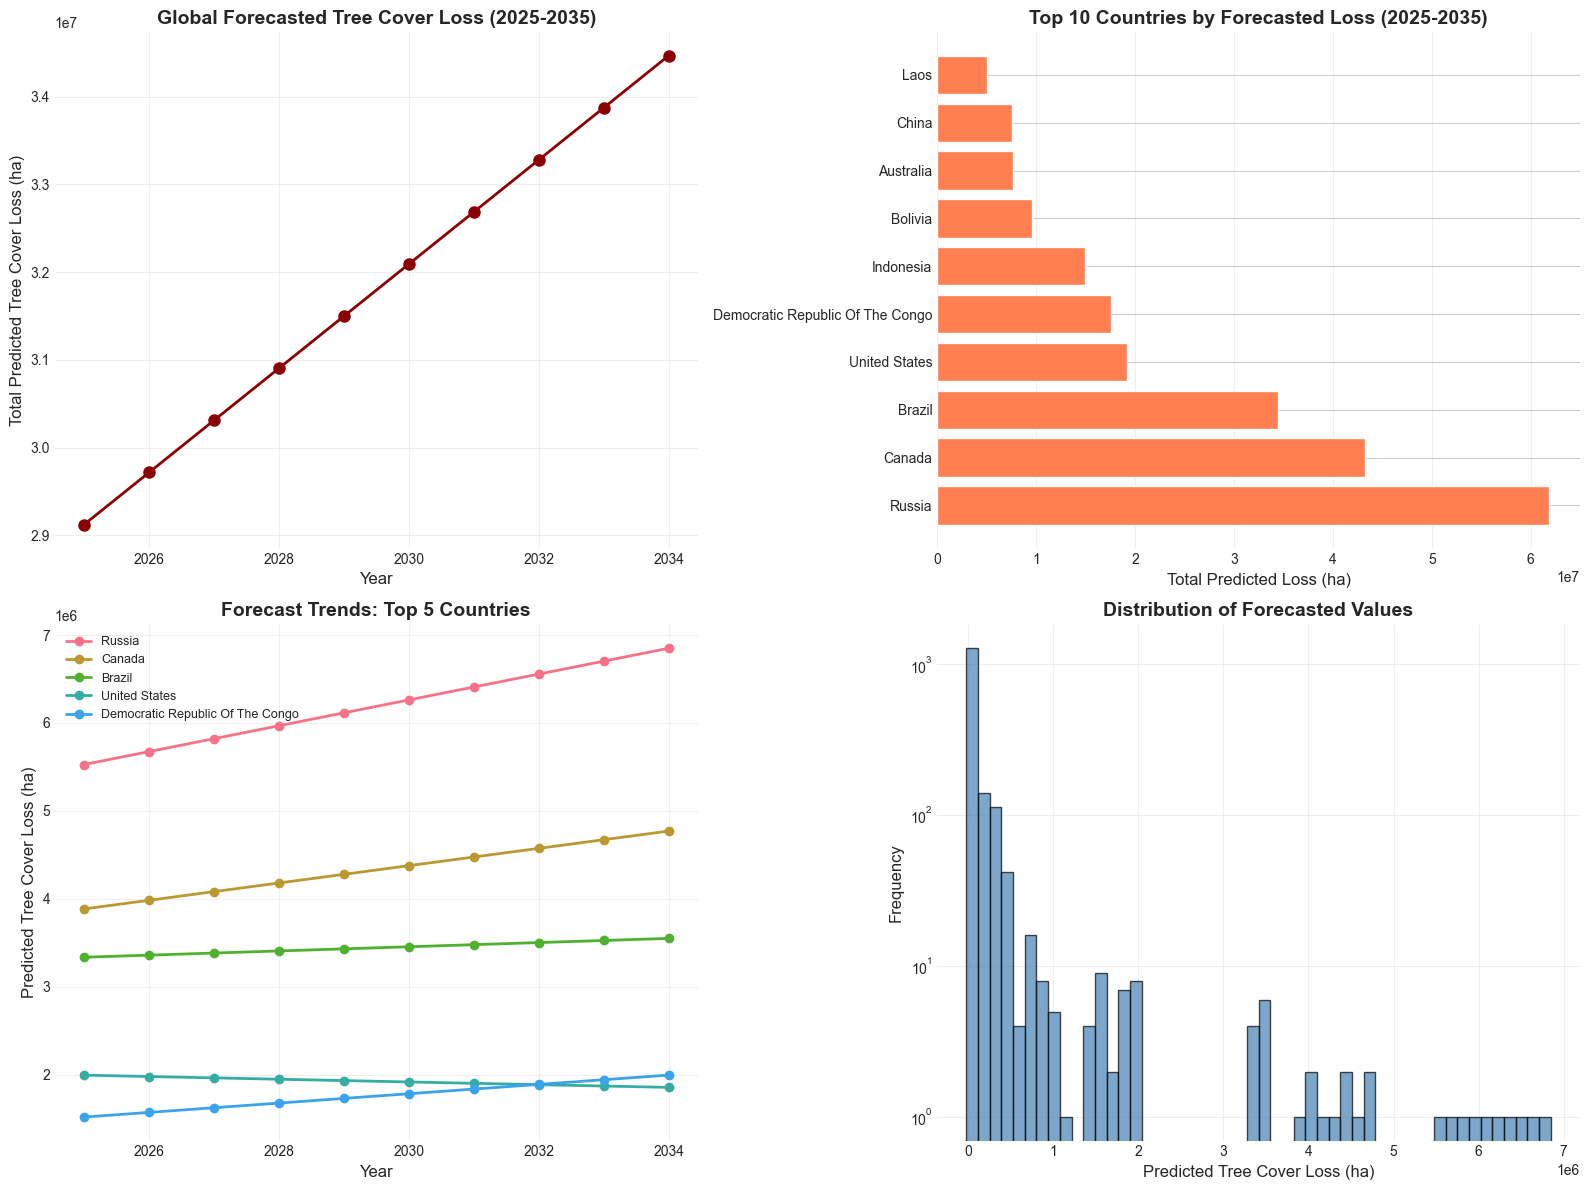

In [13]:
# Generate forecasts for all countries
print("Generating forecasts for 2025-2035...")
future_years = range(df["year"].max() + 1, df["year"].max() + 11)
rows = []

for country in sorted(df["country"].unique()):
    for year in future_years:
        val = predict_tree_loss_future(country, year)
        rows.append({"country": country, "year": year, "pred_tree_loss_ha": val})

pred_df = pd.DataFrame(rows)
pred_df.to_csv("../data/predicted_tree_cover_loss_2025_2035.csv", index=False)
print(f"\nSaved forecast table with {len(pred_df):,} predictions")
print(f"   Countries: {pred_df['country'].nunique()}")
print(f"   Years: {pred_df['year'].min()}-{pred_df['year'].max()}")

# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Global forecast trend
global_forecast = pred_df.groupby('year')['pred_tree_loss_ha'].sum()
axes[0, 0].plot(global_forecast.index, global_forecast.values, marker='o', linewidth=2, markersize=8, color='darkred')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Total Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0, 0].set_title('Global Forecasted Tree Cover Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 10 countries by total forecasted loss
top_countries_forecast = pred_df.groupby('country')['pred_tree_loss_ha'].sum().sort_values(ascending=False).head(10)
axes[0, 1].barh(range(len(top_countries_forecast)), top_countries_forecast.values, color='coral')
axes[0, 1].set_yticks(range(len(top_countries_forecast)))
axes[0, 1].set_yticklabels(top_countries_forecast.index, fontsize=10)
axes[0, 1].set_xlabel('Total Predicted Loss (ha)', fontsize=12)
axes[0, 1].set_title('Top 10 Countries by Forecasted Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Forecast trends for top 5 countries
top_5_countries = top_countries_forecast.head(5).index
for country in top_5_countries:
    country_data = pred_df[pred_df['country'] == country].sort_values('year')
    axes[1, 0].plot(country_data['year'], country_data['pred_tree_loss_ha'], marker='o', linewidth=2, label=country, markersize=6)
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 0].set_title('Forecast Trends: Top 5 Countries', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of forecasts
axes[1, 1].hist(pred_df['pred_tree_loss_ha'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Forecasted Values', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Helper for future extrapolation

In [14]:
## Helper for future extrapolation
import numpy as np


def linear_extrapolate(years, values, target_year):
    """Return linear extrapolation of `values` to `target_year`."""
    # Convert to DataFrame
    s = pd.DataFrame({"year": years, "val": values})
    
    # Convert both columns to numeric, coercing errors to NaN
    s["year"] = pd.to_numeric(s["year"], errors='coerce')
    s["val"] = pd.to_numeric(s["val"], errors='coerce')
    
    # Drop NaN values and duplicates
    s = s.dropna().drop_duplicates().sort_values("year")
    
    if len(s) >= 3:
        # Ensure values are float64
        x = s["year"].values.astype(float)
        y = s["val"].values.astype(float)
        
        # Perform linear regression
        A = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(a * target_year + b)
    
    # If not enough data, return last value or NaN
    if len(s) > 0:
        return float(s["val"].iloc[-1])
    return np.nan


### 11. Predict Tree-Cover-Loss for any country and future year

In [17]:
## 3 Predict Tree-Cover-Loss for any country and future year
bundle = joblib.load("../models/tree_cover_loss_model.pkl")
model, feature_cols = bundle["model"], bundle["features"]


def predict_tree_loss_future(country, year):
    dff = df[df["country"] == country].copy()
    if "threshold" in dff.columns:
        filt = dff[dff["threshold"] == 30]
        if not filt.empty:
            dff = filt

    if dff.empty:
        print(f"⚠️ No data for {country}")
        return None

    latest = dff.sort_values("year").tail(1).copy()

    # --- extrapolate all numeric predictors to target year ---
    for col in features:
        if col != "year":
            latest[col] = linear_extrapolate(dff["year"], dff[col], year)

    latest["year"] = year

    # encode country and align features
    enc = pd.get_dummies(latest, columns=["country"], drop_first=True)
    for c in feature_cols:
        if c not in enc.columns:
            enc[c] = 0
    X_future = enc[feature_cols].fillna(0)

    pred = model.predict(X_future)[0]
    print(f"🌲 Predicted Tree-Cover-Loss in {country} ({year}): {pred:,.0f} ha")
    return pred


# Example
predict_tree_loss_future("Brazil", 2035)
predict_tree_loss_future("Indonesia", 2030)


🌲 Predicted Tree-Cover-Loss in Brazil (2035): 3,572,488 ha
🌲 Predicted Tree-Cover-Loss in Indonesia (2030): 1,497,133 ha


np.float64(1497132.6341893068)

### 12. Forecast 2025–2035 for all countries and save

🌲 Predicted Tree-Cover-Loss in Afghanistan (2025): -2,443 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2026): -2,613 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2027): -2,783 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2028): -2,953 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2029): -3,122 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2030): -3,292 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2031): -3,462 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2032): -3,632 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2033): -3,801 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2034): -3,971 ha
🌲 Predicted Tree-Cover-Loss in Albania (2025): -947 ha
🌲 Predicted Tree-Cover-Loss in Albania (2026): -1,152 ha
🌲 Predicted Tree-Cover-Loss in Albania (2027): -1,358 ha
🌲 Predicted Tree-Cover-Loss in Albania (2028): -1,563 ha
🌲 Predicted Tree-Cover-Loss in Albania (2029): -1,768 ha
🌲 Predicted Tree-Cover-Loss in Albania (2030): -1,974 ha
🌲 Predicted Tree-Cover-Loss in Albania (2031): -2,

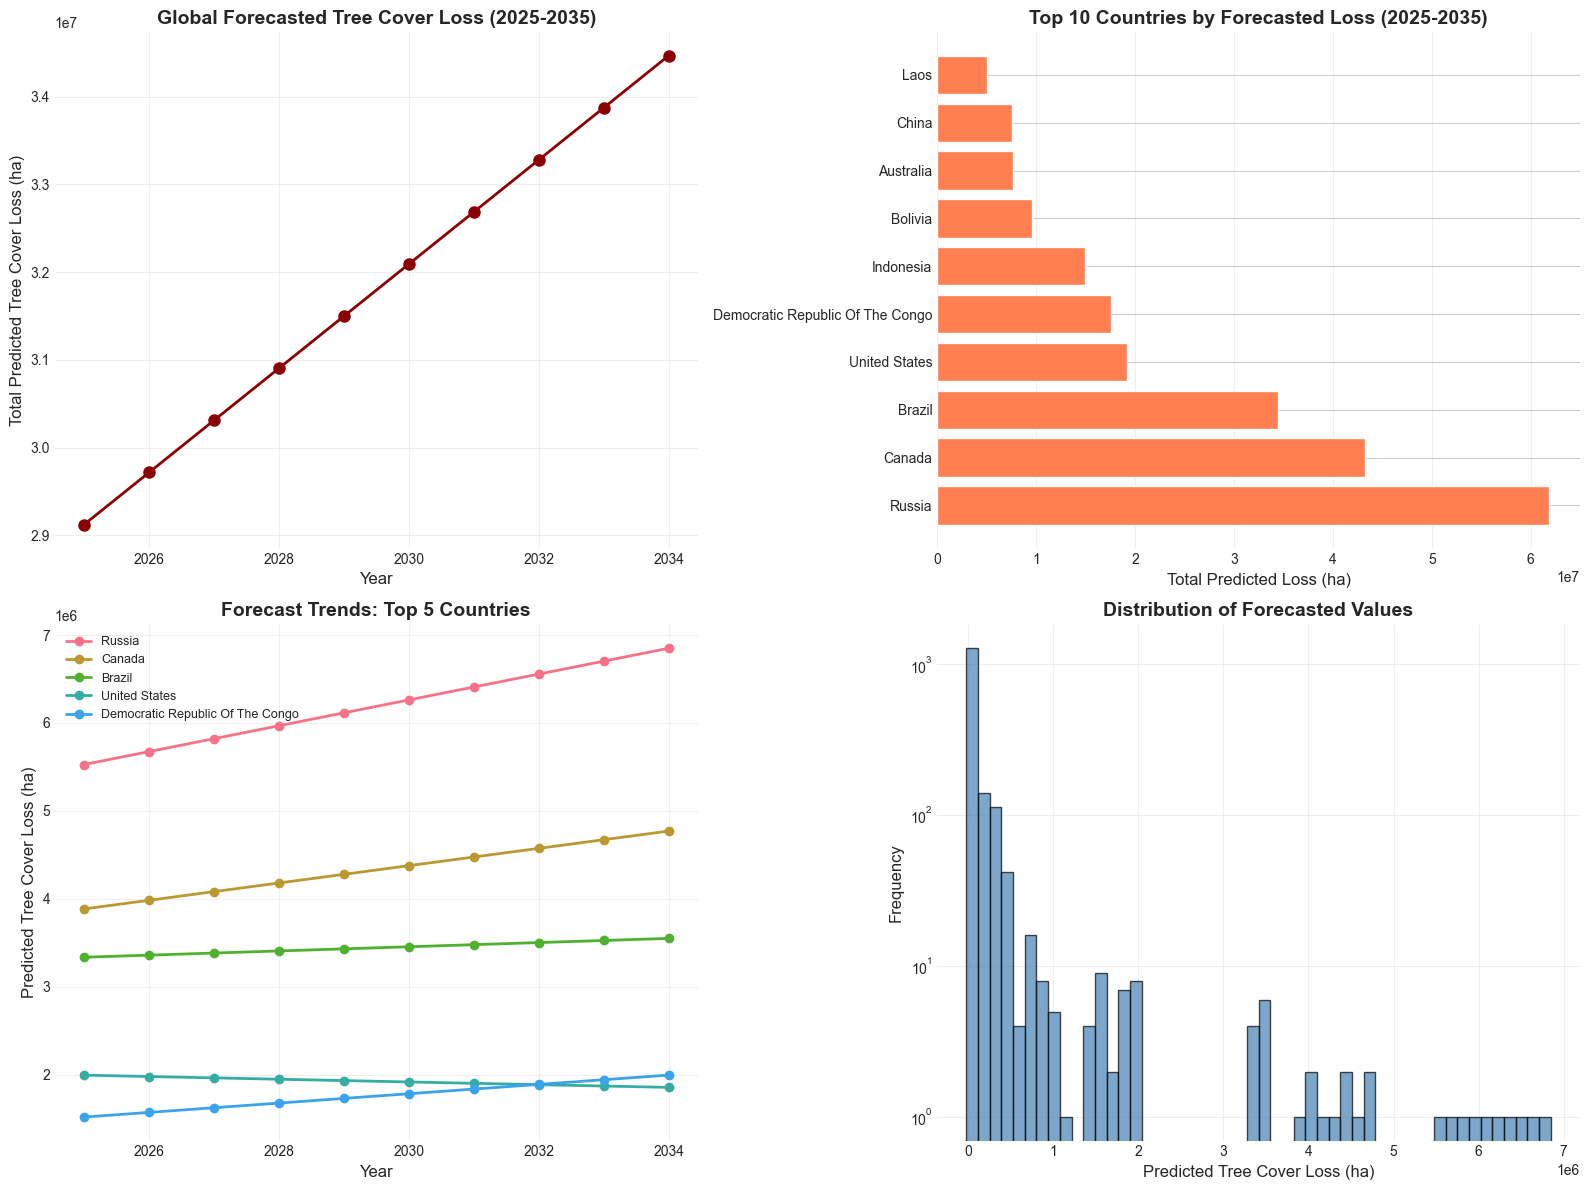

In [18]:
## Forecast 2025–2035 for all countries
future_years = range(df["year"].max() + 1, df["year"].max() + 11)
rows = []

for country in sorted(df["country"].unique()):
    for year in future_years:
        val = predict_tree_loss_future(country, year)
        rows.append({"country": country, "year": year, "pred_tree_loss_ha": val})

pred_df = pd.DataFrame(rows)
pred_df.to_csv("../data/predicted_tree_cover_loss_2025_2035.csv", index=False)
print("✅ Saved forecast table.")

# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Global forecast trend
global_forecast = pred_df.groupby('year')['pred_tree_loss_ha'].sum()
axes[0, 0].plot(global_forecast.index, global_forecast.values, marker='o', linewidth=2, markersize=8, color='darkred')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Total Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0, 0].set_title('Global Forecasted Tree Cover Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 10 countries by total forecasted loss
top_countries_forecast = pred_df.groupby('country')['pred_tree_loss_ha'].sum().sort_values(ascending=False).head(10)
axes[0, 1].barh(range(len(top_countries_forecast)), top_countries_forecast.values, color='coral')
axes[0, 1].set_yticks(range(len(top_countries_forecast)))
axes[0, 1].set_yticklabels(top_countries_forecast.index, fontsize=10)
axes[0, 1].set_xlabel('Total Predicted Loss (ha)', fontsize=12)
axes[0, 1].set_title('Top 10 Countries by Forecasted Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Forecast trends for top 5 countries
top_5_countries = top_countries_forecast.head(5).index
for country in top_5_countries:
    country_data = pred_df[pred_df['country'] == country].sort_values('year')
    axes[1, 0].plot(country_data['year'], country_data['pred_tree_loss_ha'], marker='o', linewidth=2, label=country, markersize=6)
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 0].set_title('Forecast Trends: Top 5 Countries', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of forecasts
axes[1, 1].hist(pred_df['pred_tree_loss_ha'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Forecasted Values', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()